<a href="https://colab.research.google.com/github/thisisZAQ/Decoding-Fiscal-Narratives-A-20-Year-NLP-Study-of-India-s-Union-Budgets/blob/main/Budget_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **start here**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Load the CSV file
file_path = '/content/Speech_20years.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Clean the column names by stripping extra spaces
df.columns = df.columns.str.strip()

# Drop rows with missing speech data and group by Year and Finance Minister
df_cleaned = df[['Year', 'Minister', 'Speech']].dropna()
df_grouped = df_cleaned.groupby(['Year', 'Minister'])['Speech'].apply(lambda x: ' '.join(x)).reset_index()




In [ ]:
# Calculate the length of each speech in words
df_grouped['Speech Length'] = df_grouped['Speech'].apply(lambda x: len(x.split()))

# Group by Finance Minister and calculate the total speech length for each minister
speech_length_by_minister = df_grouped.groupby('Minister')['Speech Length'].sum().reset_index()

# Sort by speech length for better visualization
speech_length_by_minister = speech_length_by_minister.sort_values(by='Speech Length', ascending=False)

# Display the results
speech_length_by_minister.head()


,Minister,Speech Length
2,P. Chidambaram,77121
0,Arun Jaitley,71043
1,Nirmala Sitharaman,59046
3,Pranab Mukherjee,51514


In [ ]:
# Calculate the length of each speech in words
df_grouped['Speech Length'] = df_grouped['Speech'].apply(lambda x: len(x.split()))

# Group by Finance Minister and calculate the total speech length for each minister
speech_length_by_minister = df_grouped.groupby('Minister')['Speech Length'].sum().reset_index()

# Sort by speech length for better visualization
speech_length_by_minister = speech_length_by_minister.sort_values(by='Speech Length', ascending=False)

# Display the results
speech_length_by_minister.head()

df_grouped.tail()
speech_length_by_minister.head()


,Minister,Speech Length
2,P. Chidambaram,77121
0,Arun Jaitley,71043
1,Nirmala Sitharaman,59046
3,Pranab Mukherjee,51514


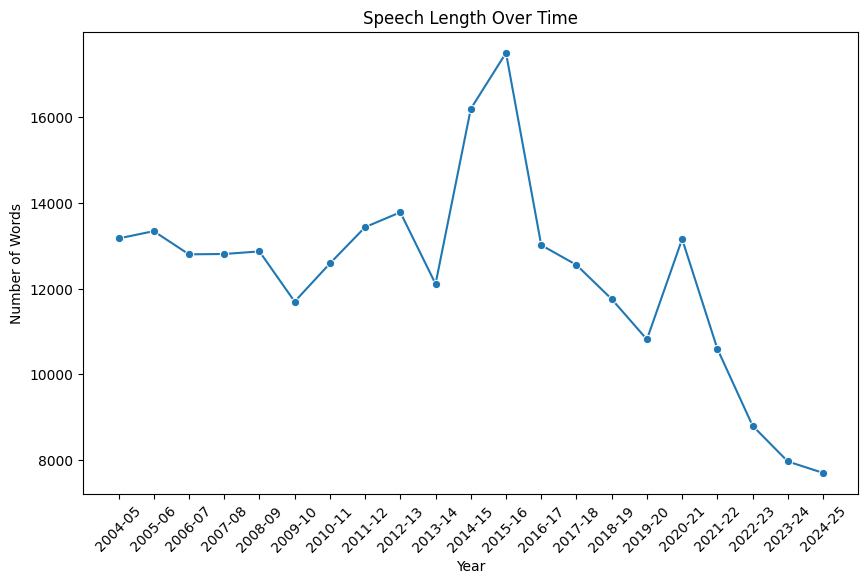

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Speech Length', data=df_grouped, marker='o')
plt.title('Speech Length Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import plotly.express as px

# Create the bar plot using Plotly Express
fig = px.bar(speech_length_by_minister,
             x='Speech Length',
             y='Minister',
             orientation='h',  # Horizontal bar plot
             title='Total Speech Length by Finance Minister',
             labels={'Speech Length': 'Speech Length (Word Count)', 'Minister': 'Minister'},
             color='Speech Length',  # Color based on speech length
             color_continuous_scale='Viridis')

# Customize layout (optional)
fig.update_layout(
    xaxis_title="Total Speech Length (Word Count)",
    yaxis_title="Finance Minister",
    height=600,
    width=900,
)

# Show the plot
fig.show()



In [ ]:
%pip install wordcloud

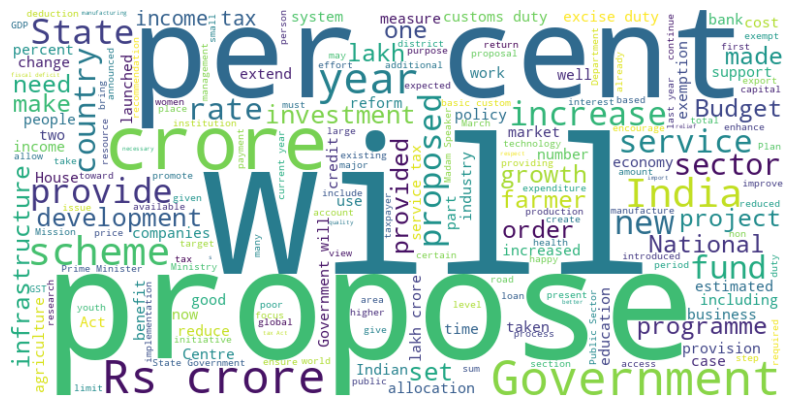

In [ ]:
from wordcloud import WordCloud

# Combine all speeches into one large text
all_text = ' '.join(df_grouped['Speech'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import spacy
from spacy import displacy

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Visualize named entities for the first speech
doc = nlp(df_grouped['Speech'][0])
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
# Define themes and associated keywords
themes = {
    'inflation': ['inflation', 'prices', 'cost of living'],
    'tax': ['tax', 'taxation', 'income tax', 'corporate tax'],
    'growth': ['growth', 'development', 'GDP', 'economy'],
    'employment': ['employment', 'jobs', 'unemployment','MSME'],
    'budget': ['deficit', 'surplus', 'expenditure'],
    'education': ['education', 'schools', 'youth','children'],
    'defence': ['defence', 'national', 'security','threat'],
}


In [ ]:
import re

# Function to count keyword occurrences for a specific theme
def count_keywords(speech, keywords):
    count = 0
    for keyword in keywords:
        count += len(re.findall(r'\b' + re.escape(keyword) + r'\b', speech.lower()))
    return count

# Add columns for each theme, counting the occurrences of theme-related words
for theme, keywords in themes.items():
    df_grouped[theme] = df_grouped['Speech'].apply(lambda x: count_keywords(x, keywords))

# Display the dataframe with theme counts
df_grouped.head()
df_grouped.info()
df_grouped.to_csv('speech_with_theme_counts.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           21 non-null     object
 1   Minister       21 non-null     object
 2   Speech         21 non-null     object
 3   Speech Length  21 non-null     int64 
 4   inflation      21 non-null     int64 
 5   tax            21 non-null     int64 
 6   growth         21 non-null     int64 
 7   employment     21 non-null     int64 
 8   budget         21 non-null     int64 
 9   education      21 non-null     int64 
 10  defence        21 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 1.9+ KB


In [ ]:
import plotly.express as px

# Group by Finance Minister and sum the keyword counts for each theme
theme_counts_by_minister = df_grouped.groupby('Minister')[list(themes.keys())].sum().reset_index()

# Melt the DataFrame to make it long-form for easier plotting
theme_counts_melted = theme_counts_by_minister.melt(id_vars='Minister', var_name='Theme', value_name='Count')

# Plot the theme mentions using Plotly Express
fig = px.bar(theme_counts_melted,
             x='Minister',
             y='Count',
             color='Theme',
              color_discrete_sequence=px.colors.qualitative.T10,
             title='Theme Mentions by Finance Minister',
             labels={'Count': 'Number of Mentions', 'Minister': 'Finance Minister'},
             barmode='group')

# Customize layout
fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Number of Mentions', height=600, width=1000)
fig.show()


In [ ]:
import plotly.express as px

# Plot the theme mentions using a stacked bar chart
fig = px.bar(theme_counts_melted,
             x='Minister',
             y='Count',
             color='Theme',
             title='Comparison of Themes by Finance Minister',
             labels={'Count': 'Number of Mentions', 'Name of Finance Minister': 'Finance Minister'},
             barmode='stack')  # Use 'stack' to create a stacked bar chart

fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Number of Mentions', height=600, width=1000)
fig.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Pivot the data to get ministers as rows and themes as columns
heatmap_data = theme_counts_by_minister.set_index('Minister')

# Create a heatmap
fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='Viridis'))

# Update layout
fig.update_layout(title='Heatmap of Theme Mentions by Finance Minister',
                  xaxis_title='Themes',
                  yaxis_title='Finance Minister',
                  height=600,
                  width=1000)

fig.show()


# LDA

In [ ]:
!pip install pandas spacy gensim pyLDAvis matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.2 MB/s eta 0:00:00


In [ ]:
import spacy
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import LdaModel

# Load spaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text (tokenization, lemmatization, stopwords removal)
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

# Define custom stopwords (domain-specific words)
custom_stopwords = ['cent', 'crore', 'propose', 'year', 'sector', 'government', 'duty', 'lakh','rate','shall','new','high','provide','rs']

# Load the spaCy model and extend its stopwords
nlp = spacy.load('en_core_web_sm')
for word in custom_stopwords:
    nlp.vocab[word].is_stop = True

# Apply preprocessing to each speech
df_grouped['tokens'] = df_grouped['Speech'].apply(preprocess)

# Create a Gensim dictionary and corpus
dictionary = Dictionary(df_grouped['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_grouped['tokens']]

# Display the processed tokens and corpus
print(dictionary)
print(corpus[:1])  # Display the first document's bag of words


Dictionary<8543 unique tokens: ['abhiyan', 'abide', 'able', 'abolish', 'abroad']...>
[[(0, 1), (1, 2), (2, 6), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 4), (12, 6), (13, 1), (14, 2), (15, 2), (16, 7), (17, 7), (18, 1), (19, 1), (20, 1), (21, 7), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 14), (28, 2), (29, 1), (30, 1), (31, 3), (32, 1), (33, 1), (34, 7), (35, 4), (36, 7), (37, 6), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 5), (45, 2), (46, 2), (47, 3), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 4), (57, 3), (58, 4), (59, 5), (60, 15), (61, 11), (62, 3), (63, 2), (64, 3), (65, 3), (66, 2), (67, 1), (68, 1), (69, 2), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 3), (77, 20), (78, 2), (79, 9), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 2), (87, 4), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 2), (94, 3), (95, 11), (96, 1), (97, 3), (98, 2), (99, 1), (100, 2), (101, 1)

In [ ]:
# Set the number of topics (you can adjust this based on the results)
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Print the topics with words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.002*"tax" + 0.001*"development" + 0.001*"investment" + 0.001*"scheme" + 0.001*"increase"')
(1, '0.012*"tax" + 0.007*"scheme" + 0.006*"service" + 0.006*"increase" + 0.006*"fund"')
(2, '0.002*"scheme" + 0.001*"tax" + 0.001*"india" + 0.001*"development" + 0.001*"state"')
(3, '0.009*"crore" + 0.007*"tax" + 0.006*"scheme" + 0.006*"state" + 0.005*"india"')
(4, '0.011*"tax" + 0.008*"india" + 0.006*"scheme" + 0.006*"income" + 0.005*"development"')


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the pyLDAvis visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization in
pyLDAvis.display(lda_display)


# Sentiment Analysis

In [ ]:
!pip install vaderSentiment


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
# Load the dataset (replace 'path_to_your_budget_file.csv' with your actual file path)
df_senti = pd.read_csv('/content/Speech_20years.csv')

# Clean the column names if needed
df_senti.columns = df.columns.str.strip()
# Replace NaN values in the 'Speech' column with an empty string
df_senti['Speech'] = df['Speech'].fillna('')


# Display the first few rows of the dataframe
df_senti.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Year,Minister,Speech,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,2004-05,P. Chidambaram,PART A,NaN,NaN,NaN,NaN,NaN
1,2004-05,P. Chidambaram,,NaN,NaN,NaN,NaN,NaN
2,2004-05,P. Chidambaram,"Mr. Speaker, Sir.",NaN,NaN,NaN,NaN,NaN
3,2004-05,P. Chidambaram,,NaN,NaN,NaN,NaN,NaN
4,2004-05,P. Chidambaram,I. INTRODUCTION,NaN,NaN,NaN,NaN,NaN


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Replace NaN values in the 'Speech' column with an empty string
df['Speech'] = df['Speech'].fillna('')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment for each speech
def get_sentiment(text):
    return analyzer.polarity_scores(text)

# sentiment analysis to each speech
df_senti['Sentiment'] = df['Speech'].apply(lambda speech: get_sentiment(speech))

# Split the VADER sentiment into individual columns
df_sentiment = df_senti['Sentiment'].apply(pd.Series)

# Merge the sentiment scores back into the original dataframe
df = pd.concat([df_senti, df_sentiment], axis=1)

# Display the updated dataframe with sentiment scores
df.head()
df.tail()
df['Year']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Year
0,2004-05
1,2004-05
2,2004-05
3,2004-05
4,2004-05
...,...
8721,2024-25
8722,2024-25
8723,2024-25
8724,2024-25


In [ ]:
# Extract the starting year from the 'Year' column
df['Year'] = df['Year'].astype(str).str.split('-').str[0]

# Convert the 'Year' column to numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Calculate the average sentiment score for each year
sentiment_over_time = df.groupby('Year')['compound'].mean().reset_index()

# Ensure the 'Year' column is sorted numerically
sentiment_over_time = sentiment_over_time.sort_values('Year')

# Plot the line chart for sentiment over time
import plotly.express as px

fig = px.line(sentiment_over_time,
              x='Year',
              y='compound',
              title='Sentiment of Budget Speeches Over Time',
              labels={'compound': 'Sentiment Score', 'Year': 'Year'})

fig.update_layout(xaxis_title='Year', yaxis_title='Average Sentiment Score')
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Calculate the average sentiment score for each finance minister
sentiment_by_minister = df.groupby('Minister')['compound'].mean().reset_index()

fig = px.bar(sentiment_by_minister,
             x='Minister',
             y='compound',
             title='Average Sentiment by Finance Minister',
             labels={'compound': 'Sentiment Score', 'Minister': 'Finance Minister'})

fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Average Sentiment Score')
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

